In [5]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/G-ZZ/jl_files/zz_samplers.jl")
include("temp.jl")

run_sampler (generic function with 3 methods)

#### Simulate data:

In [6]:
n_groups, group_size = 5, 100
Nobs = group_size*n_groups
dim_cov = 5
dim_total = 1+n_groups+dim_cov

σ02 = 1
my_pr = MM_prior(dim_cov, n_groups, σ02);

In [7]:
pX = 1e0
X = spzeros(dim_total, Nobs)
X[1,:] = 1.
X[n_groups+2:end,:] = sprandn(dim_cov, Nobs, pX)
for group in 1:n_groups
    X[group+1,((group-1)*group_size+1):(group*group_size)] = 1.
end
ξ_true = rand(Normal(),dim_total)
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) for j in 1:Nobs])
my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

#### Run sampler:

In [16]:
mb_size = 10
max_attempts = 5*10^6

lambda_list = logspace(-2,1,10)
start_overall = time()
for lambda in lambda_list 
    start = time()
    run_sampler(my_model, lambda, max_attempts, mb_size)
    print("Sampling for lambda = ", lambda, " in ", round((time()-start)/60,1), " mins \n")
end
print("Overall in ", round((time()-start_overall)/60,1), " mins")

Sampling for lambda = 0.01 in 15.3 mins 
Sampling for lambda = 0.021544346900318832 in 15.4 mins 
Sampling for lambda = 0.046415888336127795 in 15.3 mins 
Sampling for lambda = 0.1 in 15.1 mins 
Sampling for lambda = 0.2154434690031884 in 15.0 mins 
Sampling for lambda = 0.4641588833612779 in 15.1 mins 
Sampling for lambda = 1.0 in 15.2 mins 
Sampling for lambda = 2.154434690031884 in 14.8 mins 
Sampling for lambda = 4.641588833612778 in 15.0 mins 
Sampling for lambda = 10.0 in 15.3 mins 
Overall in 151.5 mins

### Plot speeds:

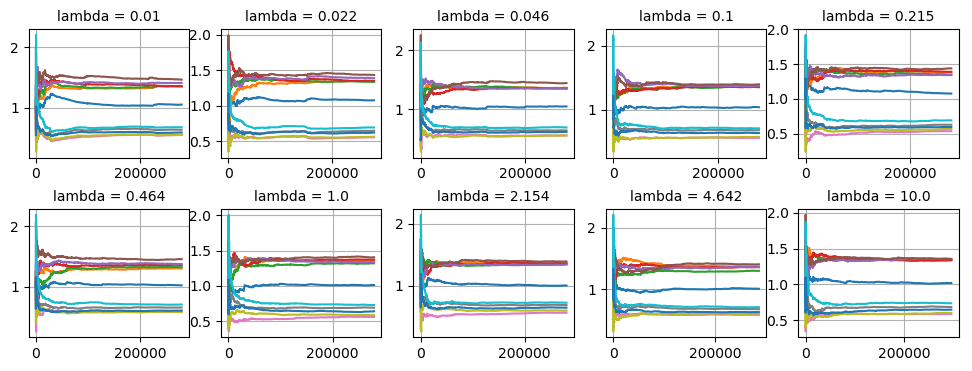

In [17]:
fig = figure("pyplot_barplot",figsize=(12,4))
for i in 1:5
    for j in 1:2 
        k = (j-1)*5+i
        filename  = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda_list[k])*
        "-dim_cov:"*string(dim_cov)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
        speed = load(filename, "alpha_skeleton")
        subplot(2,5,k)
        for dim in 1:size(speed,1)
            plot((speed[dim,:]))
            title("lambda = "*string(round(lambda_list[k],3)), fontsize=10)
            grid(true)
        end
        speed = []
        gc()
    end
end
subplots_adjust(hspace=0.4)

### Plot ACFs:

lambda = 0.01 slowest mixing = 22.2
lambda = 0.02 slowest mixing = 22.1
lambda = 0.05 slowest mixing = 23.7
lambda = 0.1 slowest mixing = 20.7
lambda = 0.22 slowest mixing = 21.8
lambda = 0.46 slowest mixing = 14.3
lambda = 1.0 slowest mixing = 15.2
lambda = 2.15 slowest mixing = 17.3
lambda = 4.64 slowest mixing = 16.3


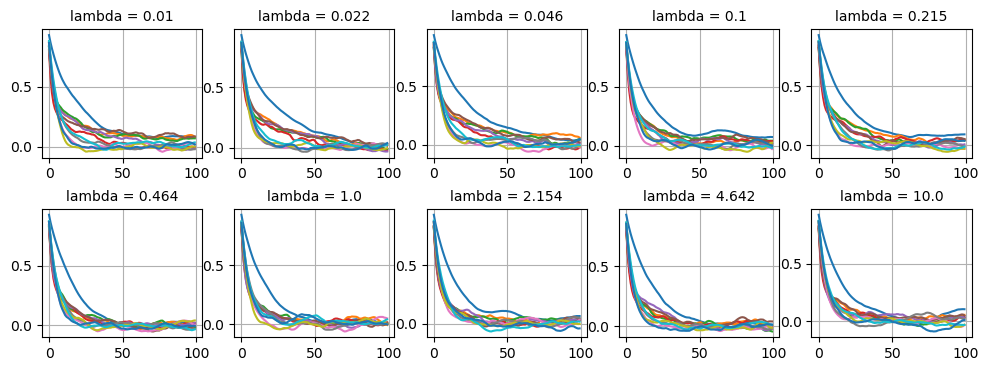

lambda = 10.0 slowest mixing = 16.0


In [22]:
fig = figure("pyplot_barplot",figsize=(12,4))
n_samples = 10^4
maxlag = 100
discard = 50_000
iacts = zeros(10)
for j in 1:2 
    for i in 1:5
        k = (j-1)*5+i
        filename  = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda_list[k])*
        "-dim_cov:"*string(dim_cov)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
        xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
        xi_samples = extract_samples(xt_skel[:,discard+1:end], 
                                     bt_skel[:,discard+1:end], 
                                    (bt_skel[end]-bt_skel[discard])/n_samples,
                                    "linear")[:,1:end-1];
        subplot(2,5,k)
        for dim in 1:size(xi_samples,1)
            plot(acf(xi_samples[dim,:],maxlag))
            title("lambda = "*string(round(lambda_list[k],3)), fontsize=10)
            grid(true)
        end
        iacts[k] = maximum([sum(acf(xi_samples[dim,:],maxlag)) for dim in 1:size(xi_samples,1)])
        print("lambda = "*string(round(lambda_list[k],2)), " slowest mixing = ", 
                round(iacts[k],1), "\n")
        xt_skel, bt_skel, xi_samples = [], [], []
        gc()
    end
end
subplots_adjust(hspace=0.4)

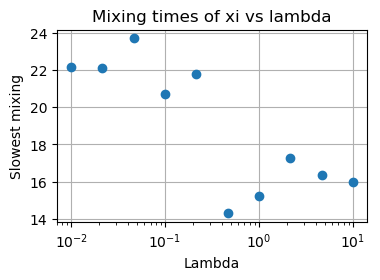

In [30]:
fig = figure("pyplot_barplot",figsize=(4,2.5))
plot(lambda_list, iacts, "o");
grid(true)
xscale("log")
xlabel("Lambda")
ylabel("Slowest mixing")
title("Mixing times of parameters vs lambda")
savefig("/home/postdoc/dsen/Desktop/G-ZZ/plots/mixing_mixed_effects.pdf", 
    format="pdf", dpi=1000, bbox_inches="tight")

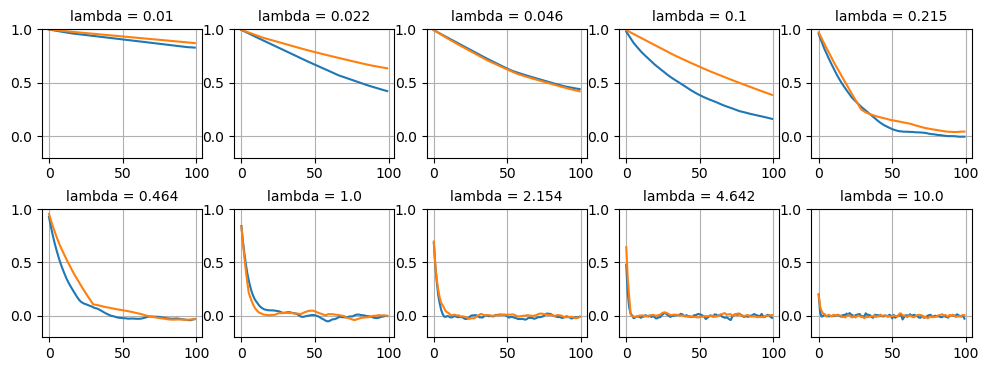

In [19]:
fig = figure("pyplot_barplot",figsize=(12,4))
n_samples = 10^4
maxlag = 100
discard = 50_000
for i in 1:5
    for j in 1:2 
        k = (j-1)*5+i
        filename  = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda_list[k])*
        "-dim_cov:"*string(dim_cov)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
        hyp_skel, bt_skel = load(filename, "hyper_skeleton", "bt_skeleton")
        hyper_samples = extract_samples(hyp_skel[:,discard+1:end], 
                                     bt_skel[:,discard+1:end], 
                                    (bt_skel[end]-bt_skel[discard])/n_samples,
                                    "constant")[:,1:end-1];
        subplot(2,5,k)
        for dim in 1:size(hyper_samples,1)
            plot(acf(hyper_samples[dim,:],maxlag))
            title("lambda = "*string(round(lambda_list[k],3)), fontsize=10)
            grid(true)
        end
        hyp_skel, bt_skel, hyper_samples = [], [], []
        gc()
        ylim(-0.2,1)
    end
end
subplots_adjust(hspace=0.4)

### HMC:

In [43]:
prior = MM_prior(dim_cov, n_groups, 1);
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

In [48]:
ξ0 = randn(dim_total)
epsilon = 2e-1
L = 20
T = 500

xi_samples, hyper_samples, acc = GibbsHMC(my_model, ξ0, epsilon, L, T);

10 percent steps in 0.0 min; HMC acceptance = 0 percent 
20 percent steps in 0.0 min; HMC acceptance = 0 percent 
30 percent steps in 0.0 min; HMC acceptance = 1 percent 
40 percent steps in 0.0 min; HMC acceptance = 1 percent 
50 percent steps in 0.0 min; HMC acceptance = 0 percent 
60 percent steps in 0.1 min; HMC acceptance = 0 percent 
70 percent steps in 0.1 min; HMC acceptance = 0 percent 
80 percent steps in 0.1 min; HMC acceptance = 0 percent 
90 percent steps in 0.1 min; HMC acceptance = 0 percent 
100 percent steps in 0.1 min; HMC acceptance = 0 percent 


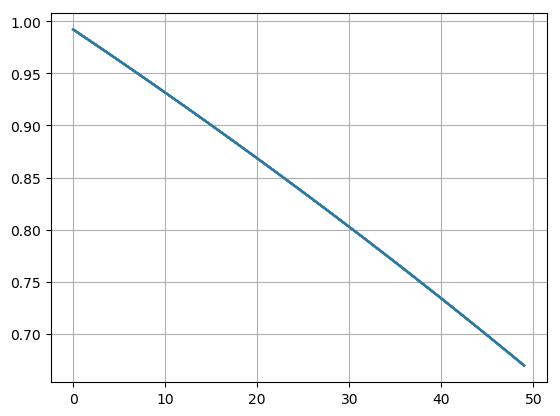

In [49]:
for i in 1:size(xi_samples,1) 
    plot(acf(xi_samples[i,:], 50))
end
grid(true)